In [16]:
import sys
import os
import re
import time
import datetime
import numpy as np
from functools import partial
import matplotlib.pyplot as plt

sys.path.append('/Users/syz/PycharmProjects/pyUSID/')
import pyUSID as usid

time_str_to_num = partial(usid.io_utils.formatted_str_to_number, 
                          magnitude_names=['msec', 'sec', 'mins', 'hours'], 
                          magnitude_values=[0.001, 1, 60, 3600], separator=' ')

def parse_compute_line(line):
    # Rank 53 - computed chunk in 2.61 mins or 147.0 msec per pixel. Average: 147.0 msec per pixel.
    matchObj = re.match(r'Rank (.*) - computed chunk in (.*) or (.*) per pixel. Average: (.*) per pixel.', line, re.M|re.I)
    type_list = [int, str, str, str]
    if matchObj:
        raw_vals = [type_caster(matchObj.group(ind)) for ind, type_caster in zip(range(1,1+len(type_list)),type_list)]
        # We are only interested in the third value - time per pixel
        return time_str_to_num(raw_vals[2])
    else:
        return None
    
def parse_write_line(line):
    # Rank 28 - wrote its 1064 pixel chunk in 6.42 sec
    matchObj = re.match(r'Rank (.*) - wrote its (.*) pixel chunk in (.*)', line, re.M|re.I)
    type_list = [int, int, str]
    if matchObj:
        raw_vals = [type_caster(matchObj.group(ind)) for ind, type_caster in zip(range(1,1+len(type_list)),type_list)]
        # We are only interested in the quotient of the third and second values
        return time_str_to_num(raw_vals[2]) / raw_vals[1]
    else:
        return None
    
def parse_execution_time(line):
    # Execution time: 167.08025765419006 sec
    matchObj = re.match(r'Execution time: (.*) sec', line, re.M|re.I)
    type_list = [float]
    if matchObj:
        raw_vals = [type_caster(matchObj.group(ind)) for ind, type_caster in zip(range(1,1+len(type_list)),type_list)]
        # We are only interested in the quotient of the third and second values
        return raw_vals[0]
    else:
        return None
    
def parse_log_filename(line):
    # Execution time: 167.08025765419006 sec
    matchObj = re.match(r'GivBenchmarkN(.*)R(.*)\.(.*)', line, re.M|re.I)
    type_list = [int, int, str]
    if matchObj:
        raw_vals = [type_caster(matchObj.group(ind)) for ind, type_caster in zip(range(1,1+len(type_list)),type_list)]
        # We are only interested in the quotient of the third and second values
        return raw_vals[:2]
    else:
        return None
    
def parse_console_logs(file_path):
    compute_times = list()
    write_times = list()
    total_time = None
    with open(file_path,mode='r') as file_handle:
        console_output = file_handle.readlines()
        for curr_line in console_output:
            ret_val = parse_compute_line(curr_line)
            if ret_val is not None:
                compute_times.append(ret_val)
                continue
            ret_val = parse_write_line(curr_line)
            if ret_val is not None:
                write_times.append(ret_val)
                continue
            ret_val = parse_execution_time(curr_line)
            if ret_val is not None:
                # Should only come here once
                total_time = ret_val
    return compute_times, write_times, total_time

In [95]:
ranks = []
compute_mean = []
compute_std = []
write_mean = []
write_std = []
total_times = []

for file_name in os.listdir('.'):
    if not file_name.startswith('GivBenchmark'): 
        continue
    nodes, ranks_per_node = parse_log_filename(file_name)
    compute_times, write_times, tot_time = parse_console_logs(file_name)
    
    ranks.append(nodes * ranks_per_node)
    compute_mean.append(np.mean(compute_times))
    compute_std.append(np.std(compute_times))
    write_mean.append(np.mean(write_times))
    write_std.append(np.std(write_times))
    total_times.append(tot_time)

# This can be of any order so sort based on ranks:
sort_order = np.array(ranks).argsort()
ranks = np.array(ranks)[sort_order]
compute_mean = np.array(compute_mean)[sort_order]
compute_std = np.array(compute_std)[sort_order]
write_mean = np.array(write_mean)[sort_order]
write_std = np.array(write_std)[sort_order]
total_times = np.array(total_times)[sort_order]

In [96]:
num_jobs = 68096
tot_time_per_pixel = np.array(compute_mean) + np.array(write_mean)
estimated_serial_time = num_jobs * tot_time_per_pixel
estimated_parallel_time = estimated_serial_time / np.array(ranks)

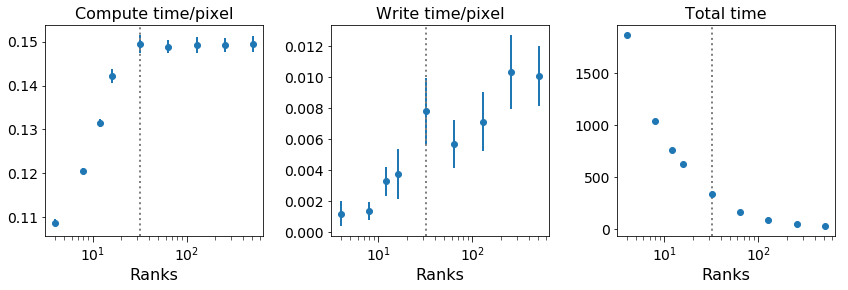

In [97]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4.25))
for axis, mean_vals, std_vals, qty_name in zip(axes.flat, 
                                              [compute_mean, write_mean, total_times],
                                              [compute_std, write_std, [0 for item in total_times]],
                                              ['Compute time/pixel', 'Write time/pixel', 'Total time']):
    #axis.scatter(ranks, mean_vals)
    axis.errorbar(ranks, mean_vals, yerr=std_vals, fmt='o')
    axis.set_xscale('log')
    axis.axvline(x=32, color='grey', ls=':')
    axis.set_title(qty_name, fontsize=16)
    axis.set_xlabel('Ranks', fontsize=16)
    
usid.plot_utils.set_tick_font_size(axes, 14)
fig.tight_layout()

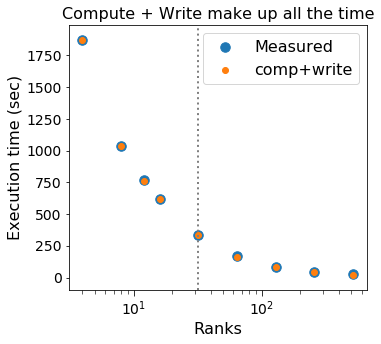

In [70]:
fig, axis = plt.subplots(figsize=(5.5, 5))
axis.scatter(ranks, total_times, s=90, label='Measured')
axis.scatter(ranks, estimated_parallel_time, label='comp+write')
axis.set_xscale('log')
axis.axvline(x=32, color='grey', ls=':')
axis.set_xlabel('Ranks', fontsize=16)
axis.set_ylabel('Execution time (sec)', fontsize=16)
axis.legend(fontsize=16)
axis.set_title('Compute + Write make up all the time')
fig.tight_layout()

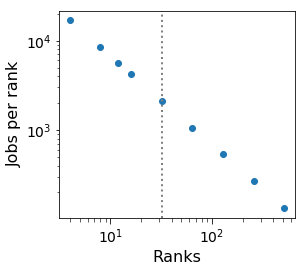

In [74]:
fig, axis = plt.subplots(figsize=(4.5, 4))
axis.scatter(ranks, num_jobs / np.array(ranks))
axis.axvline(x=32, color='grey', ls=':')
axis.set_xscale('log')
axis.set_yscale('log')
axis.set_xlabel('Ranks', fontsize=16)
axis.set_ylabel('Jobs per rank', fontsize=16)
fig.tight_layout()

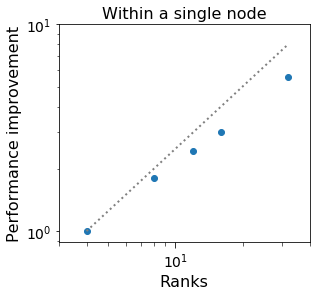

In [125]:
end_rank = np.argwhere(ranks == 32)[0][0]+1
fig, axis = plt.subplots(figsize=(4.5, 4))
axis.scatter(ranks[:end_rank], total_times[0] / total_times[:end_rank])
axis.plot(ranks[:end_rank], ranks[:end_rank]/ranks[0], color='grey', ls=':')
axis.set_xscale('log')
axis.set_yscale('log')
axis.set_xlim(right=4E+1, left=3)
axis.set_ylim(top=10)
axis.set_ylabel('Performance improvement', fontsize=16)
axis.set_xlabel('Ranks', fontsize=16)
axis.set_title('Within a single node', fontsize=16);

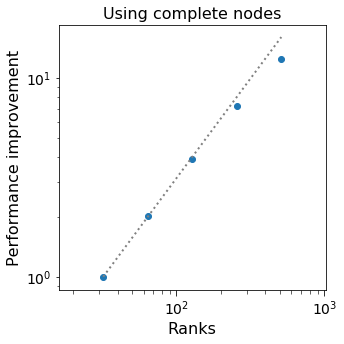

In [155]:
start_rank = np.argwhere(ranks == 32)[0][0]
fig, axis = plt.subplots(figsize=(4.5, 4))
axis.scatter(ranks[start_rank:], total_times[start_rank] / total_times[start_rank:])
axis.plot(ranks[start_rank:], ranks[start_rank:]/ranks[start_rank], color='grey', ls=':')
axis.set_xscale('log')
axis.set_yscale('log')
axis.set_xlim(left=2**4, right=2**10)
axis.set_ylabel('Performance improvement', fontsize=16)
axis.set_xlabel('Ranks', fontsize=16)
axis.set_title('Using complete nodes', fontsize=16);
fig.tight_layout()

#axis_2 = axis.twiny()
#axis_2.set_xlabel('Nodes', fontsize=16)
#axis_2.set_xlim(axis.get_xlim())
#axis_2.set_xticks(ranks[start_rank:])
#axis_2.set_xticklabels([str(x) for x in ranks[start_rank:] / 32])
#